In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from scipy import stats 
from matplotlib import gridspec
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests

[0, 2, 4, 6, 8]


### 3-fold cross validation

In [6]:
Yobs_batch = GEMS.aerobic_exp_data()
Yobs_chemo = GEMS.chemostat_exp_data()
#Yobs_batch_an = GEMS.anaerobic_exp_data()
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
sel_temp = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
Yobs_batch_an = {'data':dfan_batch.loc[sel_temp,'r_an'].values}

Yobs = {'rae':Yobs_batch['data'],
        'chemostat':Yobs_chemo['data'],
        'ran':Yobs_batch_an['data']}

In [7]:
def r2_on_dbs(simulated_data_one,Yobs,dbs):
    r2_diff_dbs = [r2_score(Yobs[db],simulated_data_one[db]) for db in dbs]
    return np.mean(r2_diff_dbs)

In [8]:
def cal_train_test_scores(model,cv,Yobs):
    cvs = {1: ['rae','chemostat'],
           2: ['rae','ran'],
           3: ['chemostat','ran']}
    test_db = [db for db in Yobs.keys() if db not in cvs[cv]]
    
    ind = 0
    train_r2s, test_r2s = [], []
    print(len(model.all_simulated_data))
    while ind <len(model.all_simulated_data):
        # training
        data_history = model.all_simulated_data[:ind+128]
        r2s_history = [(r2_on_dbs(item, Yobs, cvs[cv]),i) for i,item in enumerate(data_history)]
        r2s_history.sort()
        r2s_train_now = [item[0] for item in r2s_history[-100:]]
        train_r2s.append(r2s_train_now)
        
        # test
        #data_test =  model.all_simulated_data[ind:ind+128]
        data_test = [data_history[item[-1]] for item in r2s_history[-100:]]
        r2s_test = [r2_on_dbs(item,Yobs,test_db) for item in data_test]
        test_r2s.append(r2s_test)
        ind +=128
    return train_r2s, test_r2s

In [9]:
def _plot_confidence_interval(data,label):
    y = np.array(data)
    
    yp = np.percentile(y,[5,50,95],axis=1)
    print(len(data),y.shape,yp.shape)
    plt.plot(np.arange(len(data)),yp[1,:],label=label)
    plt.fill_between(np.arange(len(data)),yp[0,:],yp[2,:],alpha=0.5)
    

In [10]:
def plot_confidence_interval_train_test(cv,legend=True):
    model = pickle.load(open('../results/smcabc_gem_three_conditions_save_all_particles_cv{0}.pkl'.format(cv),'rb'))
    train_r2s, test_r2s= cal_train_test_scores(model,cv,Yobs)
    
    plt.figure(figsize=(3,2.4))
    _plot_confidence_interval(train_r2s,'training')
    _plot_confidence_interval(test_r2s,'test')
    
    #plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    if legend:plt.legend()
    plt.tight_layout()
    plt.savefig('../figures/cv_{0}.pdf'.format(cv))
    plt.show()
    

In [11]:
def _test_score(model,cv, Yobs):
    cvs = {1: ['rae','chemostat'],
           2: ['rae','ran'],
           3: ['chemostat','ran']}
    test_db = [db for db in Yobs.keys() if db not in cvs[cv]][0]
    
    sim_test_data_last = [res[test_db] for res in model.simulated_data]
    sim_test_data_first = [res[test_db] for res in model.simulated_data_t0[:100]]
    
    r2s_test_last = [r2_score(Yobs[test_db],item) for item in sim_test_data_last]
    r2s_test_first = [r2_score(Yobs[test_db],item) for item in sim_test_data_first]
    
    plt.boxplot([r2s_test_first,r2s_test_last],showfliers=False)
    plt.show()
    
    test_score_iterations = []
    ind = 0
    while ind <len(model.all_simulated_data):
        data_it = [res[test_db] for res in model.all_simulated_data[ind:ind+128]]
        r2s_it = [r2_score(Yobs[test_db],item) for item in data_it]
        test_score_iterations.append(np.median(r2s_it))
        ind +=128
    print(len(test_score_iterations))
    return test_score_iterations[1:]

In [12]:
def _plot(cv):
    model = pickle.load(open('../results/smcabc_gem_three_conditions_save_all_particles_cv{0}.pkl'.format(cv),'rb'))
    test_score_iterations= _test_score(model,cv, Yobs)
    
    plt.figure(figsize=(3,2.4))
    plt.plot(np.arange(len(model.epsilons)-1),-np.array(model.epsilons[1:]),'k-',linewidth=3,label='training')
    plt.plot(np.arange(len(test_score_iterations)),test_score_iterations)
    #plt.ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('$R^2$')
    plt.tight_layout()
    
    plt.show()
    print(-model.epsilons[-1])
    

5248
41 (41, 100) (3, 41)
41 (41, 100) (3, 41)


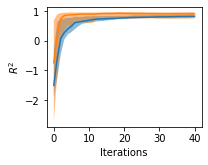

In [15]:
plot_confidence_interval_train_test(1,False)

2048
16 (16, 100) (3, 16)
16 (16, 100) (3, 16)


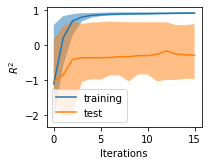

In [13]:
plot_confidence_interval_train_test(2)

4352
34 (34, 100) (3, 34)
34 (34, 100) (3, 34)


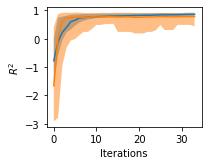

In [14]:
plot_confidence_interval_train_test(3,False)

### Train-test split based on temperature points

In [13]:
def r2s_train_test(x,y):
    # x: True Yobs, {'rae':...,'ran'}
    # y: simulated {'rae':...,}
    # Use two-fold split. points with even index as training and odd ones as test
    
    def get_r2_on_train(x,y):
        # only use those data with even index
        x = np.array(x)
        y = np.array(y)
        
        train = [ind for ind in range(len(x)) if ind%2==0]
        test = [ind for ind in range(len(x)) if ind%2==1]
        return r2_score(x[train],y[train]), r2_score(x[test],y[test])
    
    r2s_train, r2s_test = {},{}
    
    for k in x.keys(): r2s_train[k], r2s_test[k] = get_r2_on_train(x[k],y[k])
    
    return np.mean(list(r2s_train.values())), np.mean(list(r2s_test.values()))

In [14]:
a = np.array([1,3,4,2])
sort_ind = np.argsort(a)
a[sort_ind]

array([1, 2, 3, 4])

In [15]:
def find_top_100(simulated_data):
    # a list 
    r2s_train = []
    r2s_test  = []
    
    for data in simulated_data:
        r2_train, r2_test = r2s_train_test(Yobs,data)
        r2s_train.append(r2_train)
        r2s_test.append(r2_test)
    
    r2s_train = np.array(r2s_train)
    r2s_test  = np.array(r2s_test)
    sort_ind  = np.argsort(r2s_train)
    
    return r2s_train[sort_ind][-100:], r2s_test[sort_ind][-100:]
    

In [16]:
def get_r2s_in_iterations(results):
    r2s_train_in_iterations = []
    r2s_test_in_iterations = []
    end = 0
    while end < len(results.all_simulated_data):
        end += 128
        r2s_train, r2s_test = find_top_100(results.all_simulated_data[:end])
        r2s_train_in_iterations.append(r2s_train)
        r2s_test_in_iterations.append(r2s_test)
        
    r2s_train_in_iterations = np.array(r2s_train_in_iterations)
    r2s_test_in_iterations  = np.array(r2s_test_in_iterations)
    
    print(r2s_train_in_iterations.shape)
    print(r2s_test_in_iterations.shape)
    
    return r2s_train_in_iterations,r2s_test_in_iterations

In [17]:
def plot_train_test(ytrain,ytest):
    plt.figure(figsize=(4,3))
    _plot_confidence_interval(ytrain,'train')
    _plot_confidence_interval(ytest,'test')
    
    plt.xlabel('Iterations')
    
    plt.ylabel('$R^2$')
    
    
    plt.ylim([0,1])
    plt.legend()
    
    plt.tight_layout()
    
    plt.savefig('../figures/smcabc_gem_three_conditions_save_all_particles_train_test.png',dpi=300)
    plt.show()

    
    

In [18]:
results = pickle.load(open('../results/smcabc_gem_three_conditions_save_all_particles_train_test.pkl','rb'))

In [19]:
results.simulations

10496

In [20]:
r2s_train_in_iterations,r2s_test_in_iterations = get_r2s_in_iterations(results)

(82, 100)
(82, 100)


82 (82, 100) (3, 82)
82 (82, 100) (3, 82)


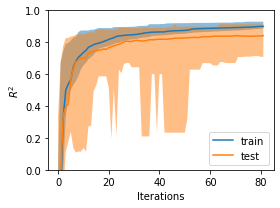

In [21]:
plot_train_test(r2s_train_in_iterations,r2s_test_in_iterations )

In [22]:
np.median(r2s_train_in_iterations[-1,:]),np.min(r2s_train_in_iterations[-1,:])

(0.8996153687820234, 0.8845973798476194)

In [23]:
np.median(r2s_test_in_iterations[-1,:])

0.8414691293587357

In [24]:
np.percentile(r2s_train_in_iterations[-1,:],[5,50,95])

array([0.88601257, 0.89961537, 0.92914632])

In [25]:
np.percentile(r2s_test_in_iterations[-1,:],[5,50,95])

array([0.70869425, 0.84146913, 0.91247406])